In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root="../../Data/", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="../../Data/", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../Data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../../Data/
    Split: Test
    StandardTransform
Transform: ToTensor()

#### Create Loaders

In [5]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


### Define strings for labels
We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that our reports line up later.

In [6]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

#### View batch of images

Lables : [    5     4     0     9     1     2     2     4     2     2]
Classes :    dog  deer plane truck   car  bird  bird  deer  bird  bird


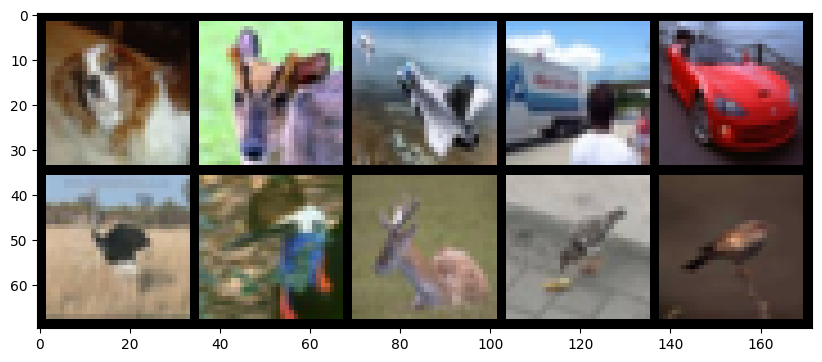

In [8]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))

#Grab the first 10 images
for images, labels in train_loader:
    break

print(f'Lables : {labels.numpy()}')
print('Classes : ', *np.array([class_names[i] for i in labels]))

#Print Images
im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

## Define the model
In the previous section we used two convolutional layers and two pooling layers before feeding data through a fully connected hidden layer to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC. We'll use the same format here.

The only changes are:
* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input<br>

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt>

In [21]:
train_data[0][0].size()

torch.Size([3, 32, 32])

In [22]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
    
        return F.log_softmax(X, dim=1)

In [24]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
model.parameters()

<generator object Module.parameters at 0x35fd8a900>

In [26]:
def count_paramters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f"_____\n{sum(params)}")
count_paramters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
_____
81302


#### Define the loss function & optimizer

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Train the model

In [30]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        #Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        #Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Clear the previously accumulated gradients
        optimizer.zero_grad()
        # Backward pass compute gradient of the loss w.r.t model parameters
        loss.backward()
        # Step optimizer to update model parameters based on the current gradient
        optimizer.step()

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)

    #Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            #Apply the model
            y_val = model(X_test)

            #Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.72117996  accuracy:  24.280%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.30930233  accuracy:  30.590%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.42613411  accuracy:  34.400%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.75467241  accuracy:  37.337%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.83105022  accuracy:  39.714%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.49445117  accuracy:  50.730%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.02976584  accuracy:  51.425%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.51676774  accuracy:  52.297%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.10714412  accuracy:  52.752%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.93527365  accuracy:  53.112%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.10933590  accuracy:  56.540%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.94397748  accuracy:  57.135%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.17520833  accuracy:  57.203%
epoch:  2  b

## Save the model
This will save your trained model, without overwriting the saved model we have provided called <strong>CIFAR10-CNN-Model-master.pt</strong>

In [31]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

#### Plot accuracy and loss comparision

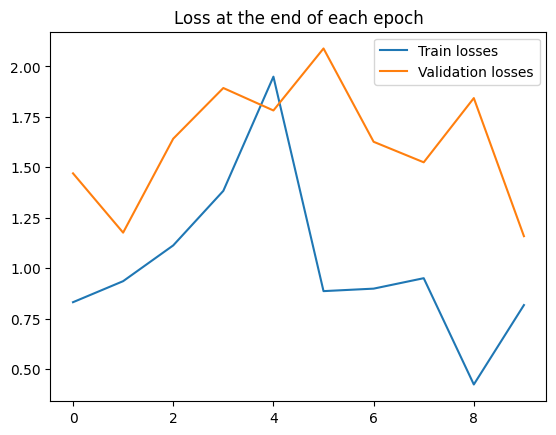

In [36]:
train_losses_numpy = [loss.detach().numpy() for loss in train_losses]
test_losses_numpy = [loss.detach().numpy() for loss in test_losses]

plt.plot(train_losses_numpy, label="Train losses")
plt.plot(test_losses_numpy, label="Validation losses")
plt.title("Loss at the end of each epoch")
plt.legend()

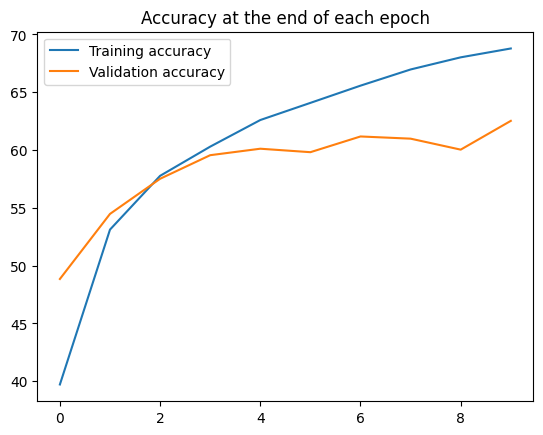

In [38]:
plt.plot([t/500 for t in train_correct], label = "Training accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation accuracy")
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [42]:
print(test_correct)
print(f"Test accuracy for the last epoch : {(test_correct[-1].item()*100)/10000}%")

[tensor(4884), tensor(5447), tensor(5751), tensor(5955), tensor(6011), tensor(5981), tensor(6117), tensor(6098), tensor(6003), tensor(6252)]
Test accuracy for the last epoch : 62.52%


## Display the confusion matrix
In order to map predictions against ground truth, we need to run the entire test set through the model.<br>
Also, since our model was not as accurate as with MNIST, we'll use a <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>heatmap</a> to better display the results.

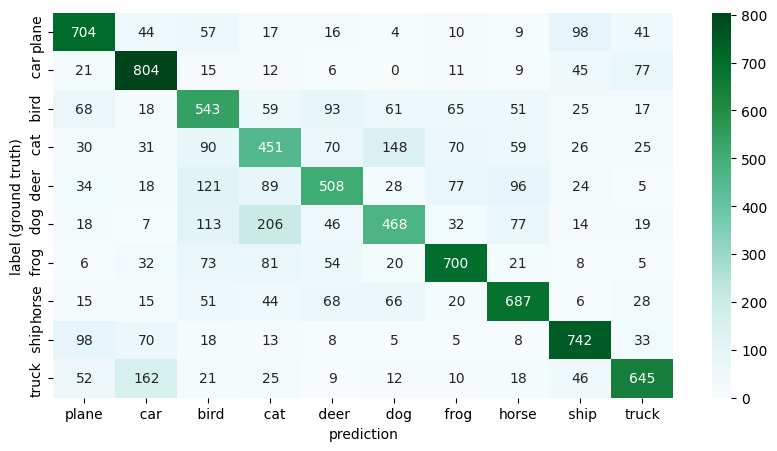

In [45]:
#Create data loader for the entire set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test, predicted)
df_cm = pd.DataFrame(arr, class_names,class_names)
plt.figure(figsize=(10,5))
sns.heatmap(data=df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()